In [ ]:
!pip install gradio
!pip install DeepPurpose
!pip install rdkit-pypi
!pip install wget

In [ ]:
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install pandas-flavor

In [3]:
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
import wget
import json
import gradio as gr
from DeepPurpose import DTI as dp_dti, utils, CompoundPred
from DeepPurpose.utils import data_process
import torch


In [5]:
from DeepPurpose.utils import convert_y_unit

In [6]:
from DeepPurpose.DTI import *

In [96]:
from DeepPurpose import DTI

In [4]:
def download_BindingDB(path = './data'):

	print('Beginning to download dataset...')

	if not os.path.exists(path):
	    os.makedirs(path)

	url = 'https://www.bindingdb.org/rwd/bind/chemsearch/marvin/SDFdownload.jsp?download_file=/bind/downloads/BindingDB_BindingDB_Articles_2D_202405_sdf.zip'
	saved_path = wget.download(url, path)

	print('Beginning to extract zip file...')
	with zipfile.ZipFile(saved_path, 'r') as zip:
	    zip.extractall(path = path)
	    print('Done!')
	path = path + '/BindingDB_All.tsv'
	return path


In [7]:
def process_BindingDB(path = None, df = None, y = 'Kd', binary = False, convert_to_log = True, threshold = 30):
	if not os.path.exists(path):
	    os.makedirs(path)

	if df is not None:
		print('Loading Dataset from the pandas input...')
	else:
		print('Loading Dataset from path...')
		df = pd.read_csv(path, sep = '\t', on_bad_lines = 'skip')
		print('Dataset loaded successfully.')
	print('Beginning Processing...')
	df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
	df = df[df['Ligand SMILES'].notnull()]

	if y == 'Kd':
		idx_str = 'Kd (nM)'
	elif y == 'IC50':
		idx_str = 'IC50 (nM)'
	elif y == 'Ki':
		idx_str = 'Ki (nM)'
	elif y == 'EC50':
		idx_str = 'EC50 (nM)'
	else:
		print('select Kd, Ki, IC50 or EC50')

	df_want = df[df[idx_str].notnull()]
	df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
					  'PubChem CID of Ligand', 'UniProt (SwissProt) Primary ID of Target Chain',\
					  'BindingDB Target Chain Sequence', idx_str]]
	df_want.rename(columns={'BindingDB Reactant_set_id':'ID',
							'Ligand SMILES':'SMILES',
							'Ligand InChI':'InChI',
							'PubChem CID of Ligand':'PubChem_ID',
							'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
							'BindingDB Target Chain Sequence': 'Target Sequence',
							idx_str: 'Label'},
							inplace=True)

	df_want['Label'] = df_want['Label'].str.replace('>', '')
	df_want['Label'] = df_want['Label'].str.replace('<', '')
	df_want['Label'] = df_want['Label'].astype(float)

	# have at least uniprot or pubchem ID
	df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
	df_want = df_want[df_want.InChI.notnull()]

	df_want = df_want[df_want.Label <= 10000000.0]
	print('There are ' + str(len(df_want)) + ' drug target pairs.')

	if binary:
		print('Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter')
		y = [1 if i else 0 for i in df_want.Label.values < threshold]
	else:
		if convert_to_log:
			print('Default set to logspace (nM -> p) for easier regression')
			y = convert_y_unit(df_want.Label.values, 'nM', 'p')
		else:
			y = df_want.Label.values

	return df_want.SMILES.values, df_want['Target Sequence'].values, np.array(y)

In [8]:
# Step 1: Download BindingDB dataset
#dataset_path = download_BindingDB()

In [64]:
# Step 2: Process BindingDB dataset
X_drugs, X_Targets, y = process_BindingDB(path="/content/BindingDB_BindingDB_Articles_202405.tsv", y='Kd', binary=False, convert_to_log=True)

Loading Dataset from path...


<ipython-input-7-0455e3f4784f>:9: DtypeWarning: Columns (7,8,10,11,13,15,17,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep = '\t', on_bad_lines = 'skip')


Dataset loaded successfully.
Beginning Processing...
There are 2385 drug target pairs.
Default set to logspace (nM -> p) for easier regression


In [65]:
# Step 3: Prepare data using DeepPurpose utils!
X_drug, X_target, y = utils.data_process(X_drugs, X_Targets, y,
                                         drug_encoding='CNN', target_encoding='CNN',
                                         split_method='random', frac=[0.7,0.1,0.2])

Drug Target Interaction Prediction Mode...
in total: 2385 drug-target pairs
encoding drug...
unique drugs: 1300
encoding protein...
unique target sequence: 438
splitting dataset...
Done.


In [66]:
print(y.shape)
print(X_target.shape)
print(X_drug.shape)

(477, 5)
(238, 5)
(1670, 5)


In [118]:
#data.head() # Keeping this here for the artifact

,SMILES,Target Sequence,Label
index,,,
0,NS(=O)(=O)c1ccccc1,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,5.394695
1,NS(=O)(=O)c1ccc(CCNC(=O)c2ccc(CN(CC([O-])=O)CC...,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,6.698970
2,NS(=O)(=O)c1ccc(CCNC(=O)c2cccc(NC(=O)CN(CC([O-...,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,7.119186
3,NS(=O)(=O)c1ccc(cc1)C(=O)NCCOCCOCCN(CC([O-])=O...,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,6.638272
4,NS(=O)(=O)c1ccc(cc1)C(=O)NCCN(CC([O-])=O)CC([O...,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,6.920819


In [13]:
from DeepPurpose import DTI
# Load pre-trained model to view layers
model = DTI.model_pretrained(model = 'CNN_CNN_BindingDB')

Dataset already downloaded in the local system...


In [14]:
if hasattr(model, 'model'):
    print(model.model)


Classifier(
  (model_drug): CNN(
    (conv): ModuleList(
      (0): Conv1d(63, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(6,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (model_protein): CNN(
    (conv): ModuleList(
      (0): Conv1d(26, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(12,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [94]:
# Step 4: Initialize model
config = {
    'drug_encoding':'CNN',  # Drug encoding type
    'target_encoding': 'CNN',  # Target encoding type
    'hidden_dim_drug': 256,  # Hidden dimension for drug encoding
    'hidden_dim_protein': 256,  # Hidden dimension for protein encoding
    'mlp_hidden_dims_drug': [256],  # MLP hidden dimensions for drug
    'mlp_hidden_dims_target': [256],  # MLP hidden dimensions for target
    'LR': 0.001,  # Learning rate
    'batch_size': 128,  # Batch size
    'train_epoch': 50,  # Number of training epochs
    'cnn_drug_filters': [32, 64, 96],  # Number of filters for each CNN layer in drug encoder
    'cnn_drug_kernels': [4, 6, 8],  # Kernel sizes for each CNN layer in drug encoder
    'cnn_target_filters': [32, 64, 96],  # Number of filters for each CNN layer in target encoder
    'cnn_target_kernels': [4, 8, 12],  # Kernel sizes for each CNN layer in target encoder
    'cls_hidden_dims': [1024, 1024, 512],  # Hidden dimensions for classifier
    'result_folder': './result/'  # Folder to store results
}



In [95]:
print(config['drug_encoding'])

CNN


In [97]:
# Initialize model
model1 = DTI.model_initialize(**config)

In [98]:
print(model1.model)

Classifier(
  (model_drug): CNN(
    (conv): ModuleList(
      (0): Conv1d(63, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(6,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (model_protein): CNN(
    (conv): ModuleList(
      (0): Conv1d(26, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(12,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)


Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 41.1133. Total time 0.0 hours
Validation at Epoch 1 with loss:16.0295, MSE: 16.9825 , Pearson Correlation: 0.20580 with p-value: 1.41E-03 , Concordance Index: 0.56410
Training at Epoch 2 iteration 0 with loss 16.7534. Total time 0.00111 hours
Validation at Epoch 2 with loss:5.19891, MSE: 5.04514 , Pearson Correlation: 0.32092 with p-value: 4.21E-07 , Concordance Index: 0.60739
Training at Epoch 3 iteration 0 with loss 5.34781. Total time 0.00222 hours
Validation at Epoch 3 with loss:3.06744, MSE: 3.27755 , Pearson Correlation: 0.48804 with p-value: 1.20E-15 , Concordance Index: 0.67602
Training at Epoch 4 iteration 0 with loss 3.08839. Total time 0.00361 hours
Validation at Epoch 4 with loss:3.28241, MSE: 3.31976 , Pearson Correlation: 0.59876 with p-value: 1.52E-24 , Concordance Index: 0.71973
Training at Epoch 5 iteration 0 with loss 3.48744. Total time 0.00472 hours
Validation

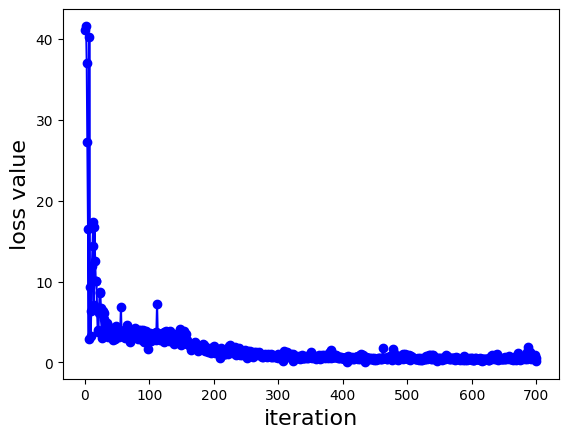

In [99]:
# Train the model
history = model1.train(X_drug, X_target, y, config)

In [40]:

# Save the model
model1.save_model('./BindingDB_50epoch_nonlog')

In [100]:
target = 'MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR'
drug = 'CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5'
drug_encoding = 'CNN'
target_encoding = 'CNN'
model = model1

In [101]:
pred1 = DTI_pred(drug, target, drug_encoding, target_encoding, model1)


Drug Target Interaction Prediction Mode...
in total: 1 drug-target pairs
encoding drug...
unique drugs: 1
encoding protein...
unique target sequence: 1
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...


In [102]:
print(pred1)

10.73 nM


In [ ]:
# 100 epochs, larger batch size

In [24]:
# Initialize model
config = {
    'drug_encoding':'CNN',  # Drug encoding type
    'target_encoding': 'CNN',  # Target encoding type
    'hidden_dim_drug': 256,  # Hidden dimension for drug encoding
    'hidden_dim_protein': 256,  # Hidden dimension for protein encoding
    'mlp_hidden_dims_drug': [256],  # MLP hidden dimensions for drug
    'mlp_hidden_dims_target': [256],  # MLP hidden dimensions for target
    'LR': 0.001,  # Learning rate
    'batch_size': 128,  # Batch size
    'train_epoch': 100,  # Number of training epochs
    'cnn_drug_filters': [32, 64, 96],  # Number of filters for each CNN layer in drug encoder
    'cnn_drug_kernels': [4, 6, 8],  # Kernel sizes for each CNN layer in drug encoder
    'cnn_target_filters': [32, 64, 96],  # Number of filters for each CNN layer in target encoder
    'cnn_target_kernels': [4, 8, 12],  # Kernel sizes for each CNN layer in target encoder
    'cls_hidden_dims': [1024, 1024, 512],  # Hidden dimensions for classifier
    'result_folder': './result/'  # Folder to store results
}



In [25]:
# Initialize model
model2 = DTI.model_initialize(**config)

Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 41.2238. Total time 0.0 hours
Validation at Epoch 1 with loss:41.7786, MSE: 40.9509 , Pearson Correlation: 0.14003 with p-value: 3.08E-02 , Concordance Index: 0.54124
Training at Epoch 2 iteration 0 with loss 38.0148. Total time 0.00111 hours
Validation at Epoch 2 with loss:20.2533, MSE: 21.5392 , Pearson Correlation: 0.13818 with p-value: 3.31E-02 , Concordance Index: 0.54781
Training at Epoch 3 iteration 0 with loss 21.6078. Total time 0.00222 hours
Validation at Epoch 3 with loss:5.54079, MSE: 5.52275 , Pearson Correlation: 0.13789 with p-value: 3.35E-02 , Concordance Index: 0.55246
Training at Epoch 4 iteration 0 with loss 6.52233. Total time 0.00333 hours
Validation at Epoch 4 with loss:4.74858, MSE: 4.21636 , Pearson Correlation: 0.24193 with p-value: 1.64E-04 , Concordance Index: 0.58108
Training at Epoch 5 iteration 0 with loss 3.34265. Total time 0.00472 hours
Validation

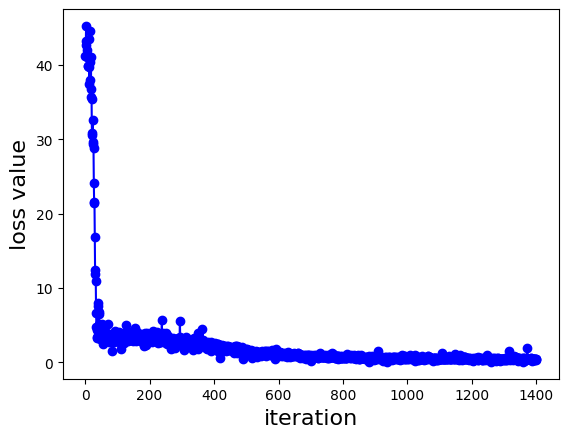

In [26]:
# Train the model
history = model2.train(X_drug, X_target, y, config)

In [27]:
# Save the model
model2.save_model('./BindingDB_100epoch')

In [88]:
# Short model fewer epochs to test theory that fewer epochs might be better
# Initialize model
config = {
    'drug_encoding':'CNN',  # Drug encoding type
    'target_encoding': 'CNN',  # Target encoding type
    'hidden_dim_drug': 256,  # Hidden dimension for drug encoding
    'hidden_dim_protein': 256,  # Hidden dimension for protein encoding
    'mlp_hidden_dims_drug': [256],  # MLP hidden dimensions for drug
    'mlp_hidden_dims_target': [256],  # MLP hidden dimensions for target
    'LR': 0.001,  # Learning rate
    'batch_size': 128,  # Batch size
    'train_epoch': 10,  # Number of training epochs
    'cnn_drug_filters': [32, 64, 96],  # Number of filters for each CNN layer in drug encoder
    'cnn_drug_kernels': [4, 6, 8],  # Kernel sizes for each CNN layer in drug encoder
    'cnn_target_filters': [32, 64, 96],  # Number of filters for each CNN layer in target encoder
    'cnn_target_kernels': [4, 8, 12],  # Kernel sizes for each CNN layer in target encoder
    'cls_hidden_dims': [1024, 1024, 512],  # Hidden dimensions for classifier
    'result_folder': './result/'  # Folder to store results
}



In [89]:
# Initialize model
model3 = DTI.model_initialize(**config)

Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 37.4594. Total time 0.0 hours
Validation at Epoch 1 with loss:4.97929, MSE: 4.78669 , Pearson Correlation: 0.10442 with p-value: 1.08E-01 , Concordance Index: 0.55936
Training at Epoch 2 iteration 0 with loss 4.28034. Total time 0.00111 hours
Validation at Epoch 2 with loss:3.31533, MSE: 3.27487 , Pearson Correlation: 0.35324 with p-value: 2.11E-08 , Concordance Index: 0.62640
Training at Epoch 3 iteration 0 with loss 4.09591. Total time 0.00222 hours
Validation at Epoch 3 with loss:3.03580, MSE: 3.24047 , Pearson Correlation: 0.56112 with p-value: 3.84E-21 , Concordance Index: 0.70352
Training at Epoch 4 iteration 0 with loss 3.11566. Total time 0.00361 hours
Validation at Epoch 4 with loss:3.48459, MSE: 3.34218 , Pearson Correlation: 0.67633 with p-value: 3.54E-33 , Concordance Index: 0.74613
Training at Epoch 5 iteration 0 with loss 3.17536. Total time 0.00472 hours
Validation

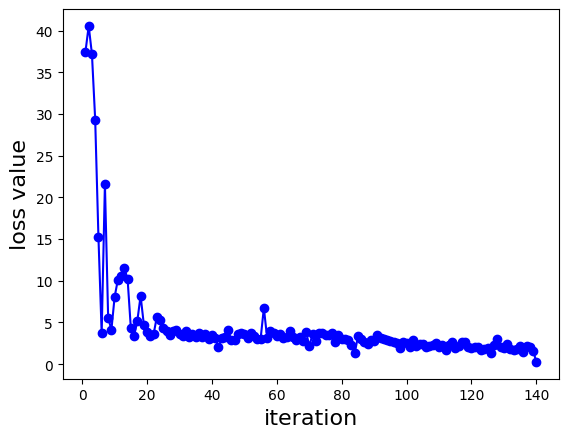

In [90]:
# Train the model
history = model3.train(X_drug, X_target, y, config)

In [91]:
target = 'MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR'
drug = 'CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5'
drug_encoding = 'CNN'
target_encoding = 'CNN'
model = model3

In [92]:
pred = DTI_pred(drug, target, drug_encoding, target_encoding, model)


Drug Target Interaction Prediction Mode...
in total: 1 drug-target pairs
encoding drug...
unique drugs: 1
encoding protein...
unique target sequence: 1
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...


In [93]:
print(pred)

587.07 nM


In [103]:
#import gradio
#import numpy as np
#from DeepPurpose import utils, DTI, CompoundPred

def DTI_pred(drug, target, drug_encoding, target_encoding, model):
    X_pred = utils.data_process(X_drug = [drug], X_target = [target], y = [0],
                                drug_encoding = drug_encoding, target_encoding = target_encoding,
                                split_method='no_split')
    y_pred = model.predict(X_pred)[0]
    y_pred = 10**(-y_pred) / 1e-9
    return f'{y_pred:.2f} nM'


def ADMET_pred(drug, ADMET_model_type, task, unit):
    model = model_ADMETs[task + '_' + ADMET_model_type + '_model']
    X_pred = utils.data_process(X_drug = [drug], y = [0],
                                drug_encoding = ADMET_model_type,
                                split_method='no_split')
    y_pred = model.predict(X_pred)[0]

    if unit == '%':
        y_pred = y_pred*100

    return f'{y_pred:.2f} ' + unit

model_DTIs = {
    'CNN-CNN': DTI.model_pretrained(model = 'CNN_CNN_BindingDB'),
    'MPNN-CNN': DTI.model_pretrained(model = 'MPNN_CNN_BindingDB'),
    'Morgan-CNN': DTI.model_pretrained(model = 'Morgan_CNN_BindingDB'),
    'Morgan-AAC': DTI.model_pretrained(model = 'Morgan_AAC_BindingDB'),
    'Daylight-AAC': DTI.model_pretrained(model = 'Daylight_AAC_BindingDB'),
    'CNN-CNN-50epochnonlog': model1,
    'CNN-CNN-100epoch': model2,
    'CNN-CNN-10epoch': model3

}

model_ADMETs = {}

for ADMET_model_type in ['MPNN', 'CNN', 'Morgan']:
    for task in ['AqSolDB', 'Caco2', 'HIA', 'Pgp_inhibitor', 'Bioavailability', 'BBB_MolNet', 'PPBR', 'CYP2C19', 'CYP2D6', 'CYP3A4', 'CYP1A2', 'CYP2C9', 'ClinTox', 'Lipo_AZ', 'Half_life_eDrug3D', 'Clearance_eDrug3D']:
        model_ADMETs[task + '_' + ADMET_model_type + '_model'] = CompoundPred.model_pretrained(model = task + '_' + ADMET_model_type + '_model')

def chem(amino_acid_sequence, molecule, affinity_model_type, ADMET_model_type):
    # affinity scores
    if len(amino_acid_sequence) > 0:
        # there is AMINO ACID SEQUENCE INPUT
        model_DTI = model_DTIs[affinity_model_type]
        affinity = DTI_pred(molecule, amino_acid_sequence, affinity_model_type.split('-')[0], affinity_model_type.split('-')[1], model_DTI)
    else:
        affinity = 'Missing Amino Acid Sequence, no Binding Affinity is predicted'

    ADMET = {}
    # physiochem
    solubility = ADMET_pred(molecule, ADMET_model_type, 'AqSolDB', 'log mol/L')
    Lipophilicity = ADMET_pred(molecule, ADMET_model_type, 'Lipo_AZ', '(log-ratio)')
    physiochem = {'Solubility': solubility, 'Lipophilicity': Lipophilicity}
    ADMET.update(physiochem)

    # absorption
    Caco2 = ADMET_pred(molecule, ADMET_model_type, 'Caco2', 'cm/s')
    HIA = ADMET_pred(molecule, ADMET_model_type, 'HIA', '%')
    Pgp = ADMET_pred(molecule, ADMET_model_type, 'Pgp_inhibitor', '%')
    bioavail = ADMET_pred(molecule, ADMET_model_type, 'Bioavailability', '%')

    absorption = {'(Absorption) Caco-2': Caco2, '(Absorption) HIA': HIA, '(Absorption) Pgp': Pgp, '(Absorption) Bioavailability F20': bioavail}
    ADMET.update(absorption)

    # distribution
    BBB = ADMET_pred(molecule, ADMET_model_type, 'BBB_MolNet', '%')
    PPBR = ADMET_pred(molecule, ADMET_model_type, 'PPBR', '%')

    distribution = {'(Distribution) BBB': BBB, '(Distribution) PPBR': PPBR}
    ADMET.update(distribution)

    # Metabolism
    CYP2C19 = ADMET_pred(molecule, ADMET_model_type, 'CYP2C19', '%')
    CYP2D6 = ADMET_pred(molecule, ADMET_model_type, 'CYP2D6', '%')
    CYP3A4 = ADMET_pred(molecule, ADMET_model_type, 'CYP3A4', '%')
    CYP1A2 = ADMET_pred(molecule, ADMET_model_type, 'CYP1A2', '%')
    CYP2C9 = ADMET_pred(molecule, ADMET_model_type, 'CYP2C9', '%')

    metabolism = {'(Metabolism) CYP2C19': CYP2C19, '(Metabolism) CYP2D6': CYP2D6, '(Metabolism) CYP3A4': CYP3A4, '(Metabolism) CYP1A2': CYP1A2, '(Metabolism) CYP2C9': CYP2C9}
    ADMET.update(metabolism)

    # Execretion
    Half_life = ADMET_pred(molecule, ADMET_model_type, 'Half_life_eDrug3D', 'h')
    Clearance = ADMET_pred(molecule, ADMET_model_type, 'Clearance_eDrug3D', 'mL/min/kg')

    execretion = {'(Execretion) Half life': Half_life, '(Execretion) Clearance': Clearance}
    ADMET.update(execretion)

    # Clinical Toxicity
    toxicity = ADMET_pred(molecule, ADMET_model_type, 'ClinTox', '%')

    clinical_toxicity = {'Clinical Toxicity': toxicity}
    ADMET.update(clinical_toxicity)

    return molecule, affinity, ADMET


Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...
Dataset already downloaded in the local system...


In [104]:
with gr.Blocks(theme=gr.themes.Soft(primary_hue="teal", secondary_hue ="orange")) as demo:
    gr.Interface(chem, [gr.components.Textbox(label = "Amino Acid Sequence", lines = 3),
                            gr.components.Textbox(label = "SMILES", lines = 3),
                            gr.components.Dropdown(label = "Affinity Prediction Model Type", choices = ['MPNN-CNN', 'CNN-CNN', 'Morgan-CNN', 'Morgan-AAC', 'Daylight-AAC', 'CNN-CNN-50epochnonlog', 'CNN-CNN-100epoch', 'CNN-CNN-10epoch']),
                            gr.components.Dropdown(label = "ADMET Prediction Model Type", choices = ['MPNN', 'Morgan', 'CNN'])],
                     [gr.components.Textbox(label = "Canonical SMILES"),
                      gr.components.Textbox(label = "Binding Affinity (Kd)"),
                      gr.components.JSON(label = "Predicted ADMET Property")],
                     description="Kexin Huang, Tianfan Fu, Dawood Khan, Ali Abid, Ali Abdalla, Abubakar Abid, Lucas M. Glass, Marinka Zitnik, Cao Xiao, Jimeng Sun. \ DeepPurpose GitHub Repository: https://github.com/kexinhuang12345/DeepPurpose || Live Website: deeppurpose.sublab.org",
                     title="[NeurIPS 2020 Demo] MolDesigner: Interactive Design of Efficacious Drugs with Deep Learning")

In [105]:
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6a88b8452446f02472.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [150]:
# Example of a prediction
print(pred1)

694.99 nM


In [ ]:
############ Future Exploration ################

In [10]:
# Define the function to load and process the KIBA dataset
def load_process_KIBA(path='./data', binary=False, threshold=9, subsample_size=0.2):
    print('Beginning Processing...')
    if not os.path.exists(path):
        os.makedirs(path)

    url = 'https://drive.google.com/uc?export=download&id=1fb3ZI-3_865OuRMWNMzLPnbLm9CktM44'
    saved_path = wget.download(url, path)

    print('Beginning to extract zip file...')
    with ZipFile(saved_path, 'r') as zip:
        zip.extractall(path=path)

    affinity = pd.read_csv(path + '/KIBA/affinity.txt', header=None, sep='\t')
    affinity = affinity.fillna(-1)

    with open(path + '/KIBA/target_seq.txt') as f:
        target = json.load(f)

    with open(path + '/KIBA/SMILES.txt') as f:
        drug = json.load(f)

    target = list(target.values())
    drug = list(drug.values())

    SMILES = []
    Target_seq = []
    y = []

    for i in range(len(drug)):
        for j in range(len(target)):
            if affinity.values[i, j] != -1:
                SMILES.append(drug[i])
                Target_seq.append(target[j])
                y.append(affinity.values[i, j])

    # Subsample the data
    indices = np.arange(len(SMILES))
    _, subsample_indices = train_test_split(indices, test_size=subsample_size, random_state=42)

    SMILES = np.array(SMILES)[subsample_indices]
    Target_seq = np.array(Target_seq)[subsample_indices]
    y = np.array(y)[subsample_indices]

    if binary:
        print('Note that KIBA is not suitable for binary classification as it is a modified score. Default binary threshold for the binding affinity scores are 9.')
        y = np.array([1 if i < threshold else 0 for i in y])

    print('Done!')
    return SMILES, Target_seq, y



In [11]:
# Example of how to call the function
SMILES, Target_seq, y = load_process_KIBA(subsample_size=0.1)


Beginning Processing...
Beginning to extract zip file...
Done!


In [12]:
# Prepare data using DeepPurpose utils
X_drug, X_target, y = utils.data_process(SMILES, Target_seq, y,
                                         drug_encoding='CNN', target_encoding='CNN',
                                         split_method='random', frac=[0.7,0.1,0.2])

Drug Target Interaction Prediction Mode...
in total: 11826 drug-target pairs
encoding drug...
unique drugs: 1838
encoding protein...
unique target sequence: 226
splitting dataset...
Done.


In [19]:
# Configuration for fine-tuning
config = {
    'drug_encoding': 'CNN',
    'target_encoding': 'CNN',
    'LR': 0.01,  # higher learning rate for fast run time
    'batch_size': 32,
    'train_epoch': 1,
    'num_workers': 0,
    'result_folder': "./result_KIBA_test_run/",
    'binary': False  # Assuming KIBA scores are continuous
}
print(config)

Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.62640. Total time 0.0 hours
Validation at Epoch 1 with loss:0.40453, MSE: 0.57034 , Pearson Correlation: 0.47505 with p-value: 1.25E-67 , Concordance Index: 0.68804
Training at Epoch 2 iteration 0 with loss 0.75875. Total time 0.00583 hours
Validation at Epoch 2 with loss:0.59213, MSE: 0.53814 , Pearson Correlation: 0.52606 with p-value: 3.59E-85 , Concordance Index: 0.69756
Training at Epoch 3 iteration 0 with loss 0.68650. Total time 0.01166 hours
Validation at Epoch 3 with loss:0.47580, MSE: 0.47304 , Pearson Correlation: 0.54972 with p-value: 2.23E-94 , Concordance Index: 0.71044
Training at Epoch 4 iteration 0 with loss 0.47054. Total time 0.0175 hours
Validation at Epoch 4 with loss:0.44102, MSE: 0.44413 , Pearson Correlation: 0.58630 with p-value: 3.75E-110 , Concordance Index: 0.71941
Training at Epoch 5 iteration 0 with loss 0.53385. Total time 0.02333 hours
Validation

NameError: name 'plt' is not defined

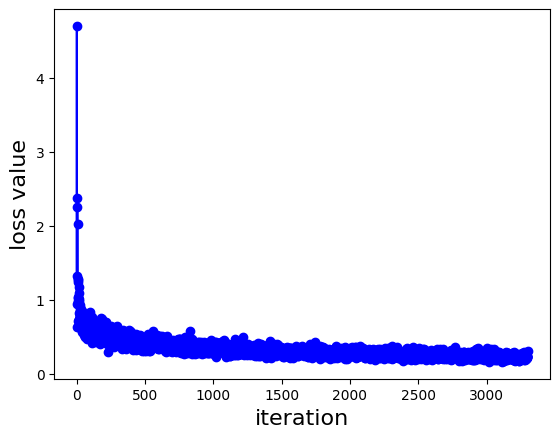

In [20]:
# Train the model
history = model.train(X_drug, X_target, y, config)

# Save the model
model.save_model('./first_test_model')